# Is COVID 19 racist?


## Introduction

### Motivation

As SARS-CoV-2 is creating havoc in the world and effecting almost every country, United States is currently the worst affected nations in the world. While it appears that everyone irrespective of the race and economic status is affected by the ill effects of the virus, I was curious to find out if that is true.

There are various different ways by which we can quantify the ill effects of COVID but the most obvious and severe effect is death.

Hence, I decided to study the death rates of COVID across different demographics and observe if there are statistically significant differences.

## Background work

There has already been some research and data points shared by CDC which show that there is some evidence of disproportionate death rate across different ethnic groups and gender. Below is the related CDC website that has links to other resources https://www.cdc.gov/coronavirus/2019-ncov/community/health-equity/race-ethnicity.html

The below two websites explores this in more details and shows a difference in death rates between various ethnic groups https://covidtracking.com/race https://covid.cdc.gov/covid-data-tracker/#demographics

However, the question that these do not answer is - "How do other factors like economic conditions, education and unemployment affect the death rates?"



## Data gathering and cleaning

In the below section we will collect data from various sources, clean it if required and then annotate the data.

But before doing that, we need to import all the dependencies required and create few helper methods.

If any of the packages do not exist, first we will install them. The below section will import any required packages. Please note that it is commented out as in most of the computers we will already have these required dependencies.

### Install required packages

In [1]:
# import sys
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install plotly
# !{sys.executable} -m pip install psutil
# !{sys.executable} -m pip install kaleido
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install wget
# !{sys.executable} -m pip install jupyter_contrib_nbextensions
# !{sys.executable} -m pip install yapf
# !{sys.executable} -m pip install statsmodels 

Now we will import the dependencies.

### Import dependencies
Below we import dependencies that are available on PyPi repository

In [2]:
import os
import json
import requests
import pandas as pd
from datetime import datetime
import plotly.express as px
import seaborn as sns
from scipy.stats import ttest_ind
import plotly.graph_objects as go
from scipy import stats
import matplotlib.pyplot as plt
import io
import requests
import wget

### Helper methods
Next the below section creates few commonly used helper methods. Please note that the helper methods 

The below method returns the extension of the file present at the url.

In [3]:
def get_extension(url):
    return os.path.splitext(url)[1]

Some of the files that we are dealing with are huge and in the order of 160MB. We want to avoid re pulling them from the source for better performance and hence we will cache it inside a folder names `data`.
The below method will enable that

In [4]:
def get_cached_file(url):
    firstpos = url.rfind("/")
    lastpos = len(url)
    file_name = url[firstpos + 1:lastpos]
    local_file_path = os.path.join("data", file_name)
    if not os.path.exists(local_file_path):
        wget.download(url, local_file_path)

    return local_file_path

### Collect ethnicity and gender data at county level

Ethnicity and gender data at county level are available at [county census](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html) website


[This](https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf) is the file that describes the various fields in the datasets

Here, we are interested in the data for latest year. The latest year available is 2019

To get the latest data for 2019, we need to pull data where YEAR=12

In [5]:
url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv"
tmp = get_cached_file(url)
demo_df = pd.read_csv(tmp, encoding='latin-1')
demo_df_year_filtered = demo_df.query("YEAR==12")

Next, we will filter out the data to get only the required columns.
We are interested in the below columns for our analysis

|Column Name   |Meaning   |
| :------------ | :------------ |
|STATE   |FIPS code for the state   |
|COUNTY   |FIPS code for the county   |
|AGEGRP   |The age group of the population   |
|WA_MALE   |White alone male population   |
|WA_MALE   |White alone male population   |
|WA_FEMALE   |White alone female population   |
|BA_MALE   |Black or African American alone male population   |
|BA_FEMALE   |Black or African American alone female population   |
|IA_MALE   |American Indian and Alaska Native alone male population   |
|IA_FEMALE   |American Indian and Alaska Native alone female population   |
|AA_MALE   |Asian alone male population   |
|NA_MALE   |Native Hawaiian and Other Pacific Islander alone male population   |
|NA_FEMALE   |Native Hawaiian and Other Pacific Islander alone female population   |

The idea here is that `STATE` and `COUNTY` are the primary keys for our dataset. We are not interested to differentiate across age groups and hence we will group by and sum across all age groups.

In [6]:
demo_interesting_columns = [
    'STATE', 'COUNTY', 'CTYNAME', 'STNAME', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
    'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
    'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE'
]

demo_filtered = demo_df_year_filtered[demo_interesting_columns]
demo_filtered.head()


,STATE,COUNTY,CTYNAME,STNAME,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE
209,1,1,Autauga County,Alabama,0,55869,27092,28777,20878,21729,5237,6000,121,145,286,370,32,26
210,1,1,Autauga County,Alabama,1,3277,1713,1564,1249,1117,339,344,4,6,24,20,3,3
211,1,1,Autauga County,Alabama,2,3465,1787,1678,1287,1191,388,368,10,9,17,25,0,2
212,1,1,Autauga County,Alabama,3,3851,1977,1874,1441,1350,442,418,3,9,18,25,2,4
213,1,1,Autauga County,Alabama,4,3659,1854,1805,1341,1334,434,400,5,0,21,13,5,3


In [7]:
demo_grouped = demo_filtered.groupby(['STATE', 'COUNTY', 'CTYNAME',
                                      'STNAME']).sum().reset_index()


We want to take proportions of the population hence we will divide by totals

In [8]:
demo_grouped['white_male'] = demo_grouped['WA_MALE']/demo_grouped['TOT_POP']
demo_grouped['white_female'] = demo_grouped['WA_FEMALE']/demo_grouped['TOT_POP']

demo_grouped['black_male'] = demo_grouped['BA_MALE']/demo_grouped['TOT_POP']
demo_grouped['black_female'] = demo_grouped['BA_FEMALE']/demo_grouped['TOT_POP']

demo_grouped['americanindian_male'] = demo_grouped['IA_MALE']/demo_grouped['TOT_POP']
demo_grouped['americanindian_female'] = demo_grouped['IA_FEMALE']/demo_grouped['TOT_POP']

demo_grouped['asian_male'] = demo_grouped['AA_MALE']/demo_grouped['TOT_POP']
demo_grouped['asian_female'] = demo_grouped['AA_FEMALE']/demo_grouped['TOT_POP']

demo_grouped['hawaai_male'] = demo_grouped['NA_MALE']/demo_grouped['TOT_POP']
demo_grouped['hawaai_female'] = demo_grouped['NA_FEMALE']/demo_grouped['TOT_POP']


In [9]:

demo_grouped['white'] = (demo_grouped['WA_MALE'] + demo_grouped['WA_FEMALE'])/demo_grouped['TOT_POP']
demo_grouped['black'] = (demo_grouped['BA_MALE'] + demo_grouped['BA_FEMALE'])/demo_grouped['TOT_POP']
demo_grouped['americanindian'] = (demo_grouped['IA_MALE'] + demo_grouped['IA_FEMALE'])/demo_grouped['TOT_POP']
demo_grouped['asian'] = (demo_grouped['AA_MALE'] + demo_grouped['AA_MALE'])/demo_grouped['TOT_POP']
demo_grouped['hawaain'] = (demo_grouped['NA_MALE'] + demo_grouped['NA_FEMALE'])/demo_grouped['TOT_POP']


In [10]:
demo_grouped['male'] = (demo_grouped['WA_MALE'] + demo_grouped['BA_MALE'] +
                        demo_grouped['IA_MALE'] + demo_grouped['AA_MALE'] +
                        demo_grouped['NA_MALE']) / demo_grouped['TOT_POP']

demo_grouped['female'] = (demo_grouped['WA_FEMALE'] + demo_grouped['BA_FEMALE'] +
                        demo_grouped['IA_FEMALE'] + demo_grouped['AA_FEMALE'] +
                        demo_grouped['NA_FEMALE']) / demo_grouped['TOT_POP']


In [11]:
demo_final_columns = [
    'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'white_male', 'white_female',
    'black_male', 'black_female', 'americanindian_male',
    'americanindian_female', 'asian_male', 'asian_female', 'hawaai_male',
    'hawaai_female', 'white', 'black', 'americanindian', 'asian', 'hawaain',
    'male', 'female', 'TOT_POP'
]

demographics_final = demo_grouped[demo_final_columns]

In [12]:
demographics_final['FIPSCODE'] = demographics_final.apply(lambda row: str(row.STATE) + str(row.COUNTY).zfill(3), axis=1)


<ipython-input-12-233e4b179700>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_final['FIPSCODE'] = demographics_final.apply(lambda row: str(row.STATE) + str(row.COUNTY).zfill(3), axis=1)


In [13]:
demographics_final['FIPSCODE']=demographics_final['FIPSCODE'].astype(int)
demographics_final.head()

<ipython-input-13-c8594d8077f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_final['FIPSCODE']=demographics_final['FIPSCODE'].astype(int)


,STATE,COUNTY,STNAME,CTYNAME,white_male,white_female,black_male,black_female,americanindian_male,americanindian_female,...,hawaai_female,white,black,americanindian,asian,hawaain,male,female,TOT_POP,FIPSCODE
0,1,1,Alabama,Autauga County,0.373696,0.388928,0.093737,0.107394,0.002166,0.002595,...,0.000465,0.762623,0.201131,0.004761,0.010238,0.001038,0.475290,0.506005,111738,1001
1,1,3,Alabama,Baldwin County,0.424711,0.449699,0.042494,0.045275,0.004045,0.003758,...,0.000358,0.874410,0.087769,0.007803,0.008350,0.000690,0.475756,0.505577,446468,1003
2,1,5,Alabama,Barbour County,0.258811,0.232723,0.255651,0.226647,0.004172,0.002714,...,0.000729,0.491534,0.482298,0.006886,0.004456,0.002106,0.522239,0.465284,49372,1005
3,1,7,Alabama,Bibb County,0.391444,0.376217,0.131330,0.081361,0.002367,0.002233,...,0.000179,0.767661,0.212691,0.004599,0.002054,0.001161,0.527150,0.461106,44788,1007
4,1,9,Alabama,Blount County,0.471380,0.486874,0.008923,0.007989,0.003320,0.003078,...,0.000432,0.958254,0.016913,0.006399,0.002940,0.001159,0.485820,0.500104,115652,1009


In [14]:
covid_deaths_path = "data/Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv"
deaths_df = pd.read_csv(get_cached_file(covid_deaths_path))
deaths_df['covid19_deaths'] = deaths_df['Deaths involving COVID-19']
deaths_df['all_deaths'] = deaths_df['Deaths from All Causes']
deaths_df['urban_rural'] = deaths_df['Urban Rural Code']


In [15]:
demo_final_columns = demo_final_columns + ['covid19_deaths', 'all_deaths', 'urban_rural', 'FIPSCODE']


In [16]:
demo_deaths_df = demographics_final.merge(deaths_df, how='inner', left_on='FIPSCODE', right_on='FIPS County Code')[demo_final_columns]

demo_deaths_df.head()

,STATE,COUNTY,STNAME,CTYNAME,white_male,white_female,black_male,black_female,americanindian_male,americanindian_female,...,americanindian,asian,hawaain,male,female,TOT_POP,covid19_deaths,all_deaths,urban_rural,FIPSCODE
0,1,1,Alabama,Autauga County,0.373696,0.388928,0.093737,0.107394,0.002166,0.002595,...,0.004761,0.010238,0.001038,0.475290,0.506005,111738,33,423,Medium metro,1001
1,1,3,Alabama,Baldwin County,0.424711,0.449699,0.042494,0.045275,0.004045,0.003758,...,0.007803,0.008350,0.000690,0.475756,0.505577,446468,96,1858,Small metro,1003
2,1,5,Alabama,Barbour County,0.258811,0.232723,0.255651,0.226647,0.004172,0.002714,...,0.006886,0.004456,0.002106,0.522239,0.465284,49372,16,229,Noncore,1005
3,1,7,Alabama,Bibb County,0.391444,0.376217,0.131330,0.081361,0.002367,0.002233,...,0.004599,0.002054,0.001161,0.527150,0.461106,44788,20,160,Large fringe metro,1007
4,1,9,Alabama,Blount County,0.471380,0.486874,0.008923,0.007989,0.003320,0.003078,...,0.006399,0.002940,0.001159,0.485820,0.500104,115652,12,404,Large fringe metro,1009


In [17]:

demo_deaths_df.shape

(1486, 26)

In [41]:
demographics_df = pd.melt(demographics_final,
                          id_vars=['STATE', 'COUNTY', 'STNAME', 'CTYNAME'],
                          value_vars=[
                              'white_male', 'white_female', 'black_male',
                              'black_female', 'americanindian_male',
                              'americanindian_female', 'asian_male',
                              'asian_female', 'hawaai_male', 'hawaai_female',
                              'white', 'black', 'americanindian', 'asian',
                              'hawaain'
                          ],
                          var_name='demo_category',
                          value_name='race_proportion')

In [61]:
race_df['gender'] = ['female' if 'female' in x else 'male' for x in demographics_df['race']]



In [60]:
# fig = px.scatter(demographics_df, x="race", y="race_proportion", color="gender", trendline="ols")

fig = px.box(demographics_df, x="race", y="race_proportion", color='gender')

fig.show()


Education attainment data is here
https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.csv?v=4779.8

Unemployment and median household income is here
https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.csv?v=4779.8

Poverty estimates are here
https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.csv?v=4779.8

population estimates are here 
https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.csv?v=4779.8

Finally COVID related deaths data are here
https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-County-and-Ra/k8wy-p9cg

## Methodology
Below are the steps that we will perform

### Data gathering and cleaning
There are few datasets that I mentioned above that are important for my analysis. My first step is to make sure that all the data is collected, cleaned and available to be used for processing.
This also includes finding any common keys that I can use to join by like the county ids etc

### Exploratory data analysis
After I have the data ready, the next step is to do exploratory data analysis on the data.
This includes looking at various charts and doing a quick review to observe and see if there are some obvious patterns.
I also plan to use some animations if required to see if some of the data changes with time.
The next step is to validate the specific research questions that I have already mentioned in the Research questions section.
As I explore the research questions, I may come across various hypothesis that may seem convincing but I want to go a step further and ensure that they are statistically sound and hence I will do some hypothesis testing. 


### Install requirements
Before, we start, please ensure that you have the below requirements.
You can install them by uncommenting the below code snippet. It is commented on purpose to allow you of a chance to install the requirements using your preferred package managers

# Import python dependencies
Before we do any processing, we need to import all required libraries for python. These are available on PyPi repository

In [37]:
# tmp = pd.read_csv("https://raw.githubusercontent.com/cs109/2014_data/master/countries.csv")
# tmp = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv", encoding='latin-1')
eth_cols = pd.DataFrame(tmp.columns, columns=["Column Name"], index=None)
eth_cols.style.hide_index()
with pd.option_context('display.max_rows', None):
    display(eth_cols)
# Helper methods
# def get_df_from_url(url):
#     s=requests.get(url).content
#     df=pd.read_csv(io.StringIO(s.decode('utf-8')))
#     return df

,Column Name
0,SUMLEV
1,STATE
2,COUNTY
3,STNAME
4,CTYNAME
5,YEAR
6,AGEGRP
7,TOT_POP
8,TOT_MALE
9,TOT_FEMALE


In [25]:
tmp.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE',
       'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE',
       'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE',
       'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
       'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE',
       'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE',
       'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE',
       'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE', 'NHWAC_FEMALE',
       'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE', 'NHIAC_FEMALE',
       'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE',
       'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE',
       'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE

In [24]:
tmp['COUNTY'].unique()

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133,  16,  20,  50,  60,  68,  70,  90, 100, 110, 122, 130,
       150, 158, 164, 170, 180, 185, 188, 195, 198, 220, 230, 240, 261,
       275, 282, 290,  12, 135, 137, 139, 141, 143, 145, 147, 149,  14,
        86, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173,
       175, 177, 179, 181, 183, 187, 189, 191, 193, 197, 199, 201, 205,
       207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231,
       233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257,
       259, 263, 265, 267, 269, 271, 273, 277, 279, 281, 283, 285, 287,
       289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 31

## Findings

## Limitations and implications

1. Ethnicity and gender data at county level is available only for 2019. The assumption here is that there is not a big difference in population statistics in a year.
2. Out of the 3143 counties, we have covid death data only for 1486 counties.

## Conclusion

## References

# Question 1

## Motivation

My motivation for the the first analysis is that I want to analyze and observe if workers who think negatively about the aggressiveness of the corpus provide demographics.
The reason behind this analysis is that I feel people who have strong opinion may give negative comments but shy away from disclosing about themselves.

This would mean that some of the corpus is unnecessarily penalized by workers who have strong opinions but might not disclose themselves.

Hence the DataSet chosen is aggressiveness
And the specific Question is

### Is there a difference in the score given by workers who provide their demographic information versus those who do not

But, we cannot do the analysis all in once, lets follow each steps

# Import data


In [3]:
dataset_name = 'aggression'
dir_name = '4267550'
annotations = pd.read_csv('../{dir_name}/{dataset_name}_annotations.tsv'
                          .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                          header=0)
annotated_comments = pd.read_csv('../{dir_name}/{dataset_name}_annotated_comments.tsv'
                                 .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                 header=0)
worker_demographics = pd.read_csv('../{dir_name}/{dataset_name}_worker_demographics.tsv'
                                             .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                             header=0)



# EDA

## Observe the columns
Lets first observe what column each dataset has and can we join on some columns

In [4]:
print(annotations.columns)
print(annotated_comments.columns)
print(worker_demographics.columns)

Index(['rev_id', 'worker_id', 'aggression', 'aggression_score'], dtype='object')
Index(['rev_id', 'comment', 'year', 'logged_in', 'ns', 'sample', 'split'], dtype='object')
Index(['worker_id', 'gender', 'english_first_language', 'age_group',
       'education'],
      dtype='object')


Now, lets check the size of data in these dataframes

In [5]:
print(annotations.shape)
print(annotated_comments.shape)
print(worker_demographics.shape)

(1365217, 4)
(115864, 7)
(2190, 5)


Lets first take a mean of score per worker id. This will allow us to do more EDA and analyze the effect of worker demographics on their scoring

In [6]:
mean_score_per_worker = annotations.groupby("worker_id").mean().reset_index()[['worker_id', dataset_name + '_score']]
mean_score_per_worker.rename(columns={dataset_name + '_score': 'score'}, inplace=True)


In [7]:
mean_score_per_worker.head(3)

,worker_id,score
0,0,-0.461388
1,1,-0.092138
2,2,0.000000


In [8]:
all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


(4053, 7)
(2190, 7)
(1863, 7)


In [9]:
scores_with_no_demographics.head(3)

,worker_id,score,gender,english_first_language,age_group,education,demo_present
1,1,-0.092138,NaN,NaN,NaN,NaN,left_only
2,2,0.000000,NaN,NaN,NaN,NaN,left_only
3,3,-0.050242,NaN,NaN,NaN,NaN,left_only


## Analyzing if there is any difference

Now, since we have the 2 groups, lets try to visually see if we can observe any difference. We shall use a boxplot to observe the difference.

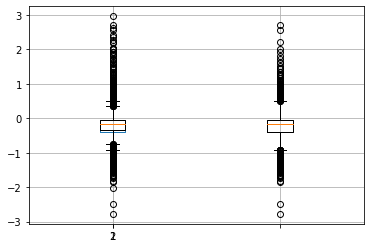

In [10]:
pd.DataFrame(scores_with_no_demographics['score']).boxplot()
plt.boxplot([scores_with_demographics['score'], scores_with_no_demographics['score']])
plt.show()

We do observe some difference but, it would be better to visualize this in a slightly better fashion so that we can also observe the shape of the variance.
Hence, we shall use a violin plot.

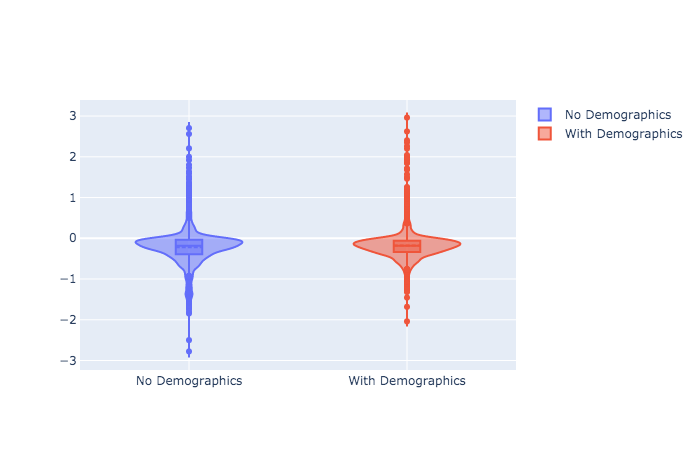

In [11]:
fig = go.Figure()

fig.add_trace(go.Violin(y=scores_with_no_demographics['score'],
                        box_visible=True,
                        name='No Demographics',
                        meanline_visible=True))

fig.add_trace(go.Violin(y=scores_with_demographics['score'],
                        box_visible=True,
                        name='With Demographics',
                        meanline_visible=True))
fig.update_layout(autosize=True)
fig.show("png")

### Observation 1
The above visual shows that there is a difference but it is not very clear on how much is the difference

Lets print it out for comparison

In [12]:
with_demo_mean = scores_with_demographics['score'].mean()
with_demo_var = scores_with_demographics['score'].var()


no_demo_mean = scores_with_no_demographics['score'].mean()
no_demo_var = scores_with_no_demographics['score'].var()

print('Data with identified demographics has mean = {with_demo_mean} and \
variance={with_demo_var} and Data with no demographics has mean = {no_demo_mean} \
and variance={no_demo_var}'.format(with_demo_mean=with_demo_mean,
                                    with_demo_var=with_demo_var,no_demo_mean=no_demo_mean,
                                    no_demo_var=no_demo_var))

Data with identified demographics has mean = -0.17531208754349292 and variance=0.1353670174426749 and Data with no demographics has mean = -0.22184714196905714 and variance=0.21386974280469004


### Observation 2
As we see above, the mean are indeed different but we are not yet convinced if this difference is statistically significant.
Hence, we will do a t-test.

## T-Test
### H0 (null hypothesis) - The mean score of the group which has provided demographics is same as the mean score of the group which has not provided demographic information
### H1(alternate hypothesis) - The mean score of the group which has provided demographics is not same as the mean score of the group which has not provided demographic information

In [13]:
ttest,pval = ttest_ind(scores_with_no_demographics['score'],scores_with_demographics['score'])
if pval <0.05:
    print("We reject null hypothesis")
else:
    print("we fail to reject the null hypothesis")

We reject null hypothesis


## Conclusion
There indeed is a statistically significant difference in the mean values of the group that provided demographics vs the group that did not provide demographics.
This indicates that there indeed is a bias in the crowd sourced scores where crowd sourcers who do not wish to be identified have provided a more negative aggression score.

The implications of this conclusion is that, the result obtained by running the getting the score from crowdflower workers maybe heavily weighing towards workers who do not want to provide their information but want to give negative comments.

# Question 2

## Motivation
My motivation for this question was to study the toxicity dataset and identify any possible biases due to the demographic profiles of the crowdflower workers.

Below was the specific question

## Is there a difference in the average score for toxicity dataset between gender and education level for different workers. And if yes is it sufficient to raise issues about bias

In order to find this, we will use `scores_with_demographics` as it contains `gender` and `education` information.

Let us first observe if these levels for all the workers is equal.
In order to do this, we analyze the counts of these dataframes.
Before this, we will remove the gender=other

# Import data


In [14]:
dataset_name = 'toxicity'
dir_name = '4563973'
annotations = pd.read_csv('../{dir_name}/{dataset_name}_annotations.tsv'
                          .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                          header=0)
annotated_comments = pd.read_csv('../{dir_name}/{dataset_name}_annotated_comments.tsv'
                                 .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                 header=0)
worker_demographics = pd.read_csv('../{dir_name}/{dataset_name}_worker_demographics.tsv'
                                             .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                             header=0)



# EDA

## Observe the columns
Lets first observe what column each dataset has and can we join on some columns

In [15]:
print(annotations.columns)
print(annotated_comments.columns)
print(worker_demographics.columns)

Index(['rev_id', 'worker_id', 'toxicity', 'toxicity_score'], dtype='object')
Index(['rev_id', 'comment', 'year', 'logged_in', 'ns', 'sample', 'split'], dtype='object')
Index(['worker_id', 'gender', 'english_first_language', 'age_group',
       'education'],
      dtype='object')


Now, lets check the size of data in these dataframes

In [16]:
print(annotations.shape)
print(annotated_comments.shape)
print(worker_demographics.shape)

(1598289, 4)
(159686, 7)
(3591, 5)


Lets first take a mean of score per worker id. This will allow us to do more EDA and analyze the effect of worker demographics on their scoring

In [17]:
mean_score_per_worker = annotations.groupby("worker_id").mean().reset_index()[['worker_id', dataset_name + '_score']]
mean_score_per_worker.rename(columns={dataset_name + '_score': 'score'}, inplace=True)


In [18]:
mean_score_per_worker.head(3)

,worker_id,score
0,0,-0.208768
1,1,0.000000
2,2,0.258403


In [19]:
all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


(4301, 7)
(3591, 7)
(710, 7)


In [20]:

all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


scores_with_no_demographics.head(3)

(4301, 7)
(3591, 7)
(710, 7)


,worker_id,score,gender,english_first_language,age_group,education,demo_present
2,2,0.258403,NaN,NaN,NaN,NaN,left_only
4,4,-0.105263,NaN,NaN,NaN,NaN,left_only
16,16,0.730361,NaN,NaN,NaN,NaN,left_only


In [21]:
scores_with_demographics = scores_with_demographics[scores_with_demographics['gender'] != 'other']

Next, lets try to see the difference in various levels

In [22]:
gender_education = scores_with_demographics.groupby(['gender', 'education']).count().reset_index()[['gender', 'education', 'worker_id']]
gender_education['count_of_records'] = gender_education['worker_id']
gender_education.head(200)


,gender,education,worker_id,count_of_records
0,female,bachelors,530,530
1,female,doctorate,16,16
2,female,hs,349,349
3,female,masters,196,196
4,female,professional,136,136
5,female,some,36,36
6,male,bachelors,911,911
7,male,doctorate,25,25
8,male,hs,676,676
9,male,masters,350,350


Lets visualize this on a scatter plot to get a better feel for each of these groups

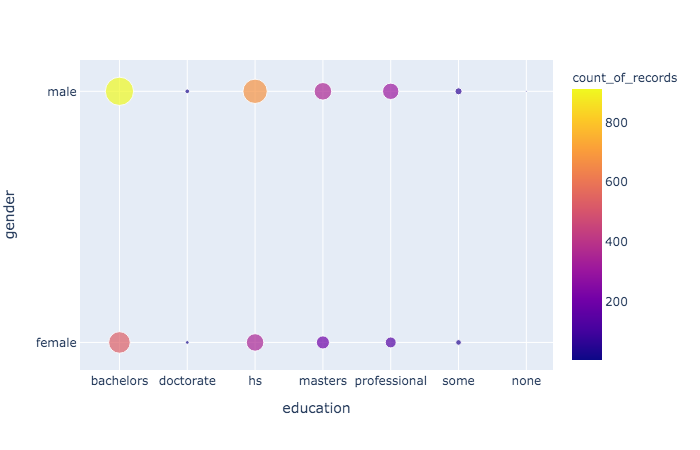

In [23]:
fig = px.scatter(gender_education, x="education", y="gender", color="count_of_records",
                 size='count_of_records', hover_data=['gender', 'education'])
fig.show("png")

As we observe, the groups are indeed not equal and it seems that males with bachelor degree have much higher representation that female with doctorate degree.

As next step, one by one, lets try to analyze if there is a difference in the mean score for different groups.

First, lets analyze if there is a difference in the mean score for gender.

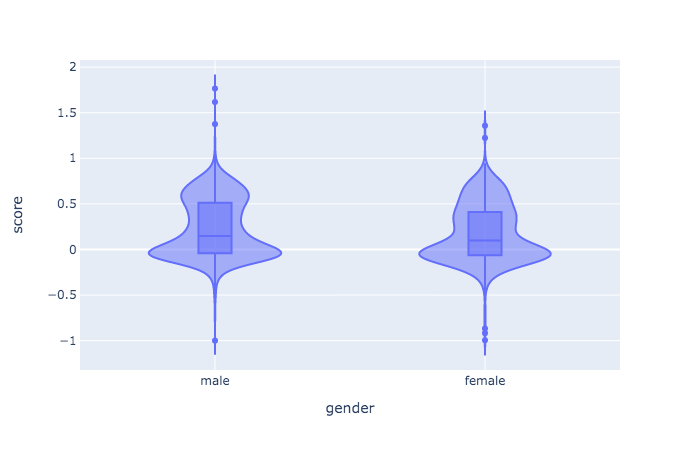

In [24]:
fig = px.violin(scores_with_demographics, x="gender", y="score", box = True, points='outliers')
fig.show("png")

As we observe there is some difference but we want to see if there is even a larger difference if we consider gender and education.

So, now, lets see if there is overall difference with the combined groups

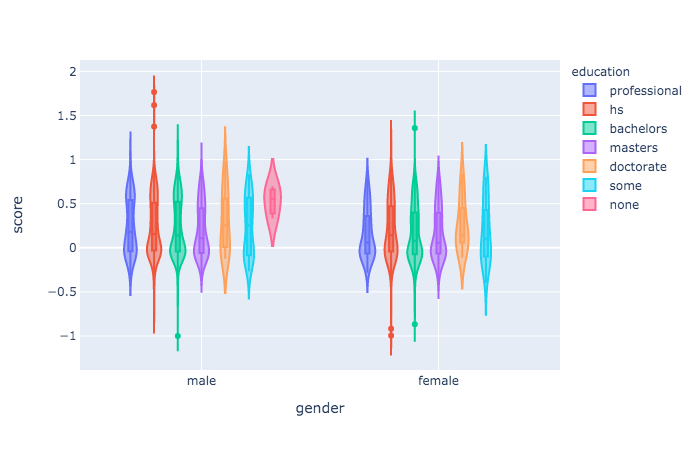

In [25]:
fig = px.violin(scores_with_demographics, x="gender", y="score", color='education', 
                box = True, points='outliers', hover_data=['gender', 'education'])
fig.show("png")

We do see that there is a difference in the mean scores for all the groups.

It will be however convenient to see both the count of records and mean score on a single chart, this will make it easier for us to compare.
For that, we will first need to get a dataframe with both count and means

In [26]:
gender_education_means = scores_with_demographics.groupby(['gender', 'education']).mean().reset_index()[['gender', 'education', 'score']]
gender_education_means.head(200)


,gender,education,score
0,female,bachelors,0.163844
1,female,doctorate,0.248517
2,female,hs,0.208419
3,female,masters,0.163795
4,female,professional,0.156051
5,female,some,0.186719
6,male,bachelors,0.230790
7,male,doctorate,0.293121
8,male,hs,0.235189
9,male,masters,0.196832


Next, we shall combine both the dataframes - the one with count and another with mean

In [27]:
score_count = gender_education.merge(gender_education_means, how='inner', on=['gender', 'education'])
score_count[['gender', 'education', 'count_of_records', 'score']]


,gender,education,count_of_records,score
0,female,bachelors,530,0.163844
1,female,doctorate,16,0.248517
2,female,hs,349,0.208419
3,female,masters,196,0.163795
4,female,professional,136,0.156051
5,female,some,36,0.186719
6,male,bachelors,911,0.230790
7,male,doctorate,25,0.293121
8,male,hs,676,0.235189
9,male,masters,350,0.196832


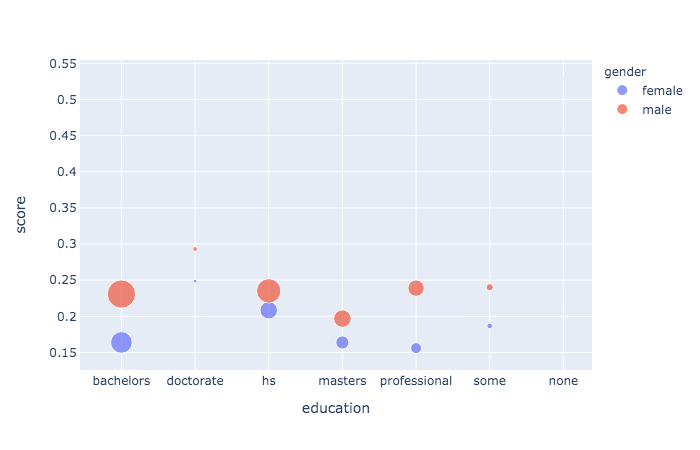

In [28]:
fig = px.scatter(score_count, x='education', y="score", color='gender',
                 size='count_of_records', hover_data=['gender', 'education'])
fig.show("png")

## Conclusion

In the above plot, we see that males have been slightly forgiving when it comes to giving a score for toxicity.
This is even more profound since males with bachelor and high school education level have more number of scores which could skew the final result.

So, indeed there is a bias in the scores based on the gender and education level which favors males with education level in bachelors or hs over female in education level of doctorate or professional.

## Implications for research and product development

The main objective of doing the above work was to study if there is any bias in the crowdsourced scores.
After doing the above test, we do see an evidence for 2 kinds of biases
1. In the aggression dataset, people who chose to provide their demographic information tend to be more forgiving vs those who did not. Specifically, it appears as the group that had strong negative opinion avoided providing the demographic information.
2. In the toxicity dataset, not all population groups are appropriately represented. Specifically, males with education level of bachelor and hs are more than female with doctorate or professional and the scores given by them are more forgiving and seem to be skewing the overall results for items in the corpus to be more lenient.

Below are my reflections on the various questions


### What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why? 

Based on the analysis that I did, I feel, that the application "Authorship feedback" would perform better and is better supported. The reason is, I believe that the aggression scores provided by the workers are biased by people not providing demographic information and giving a negative score. Also, the toxicity scores are more skewed by lenient males.
The "Authorship feedback" is an application where there is a chance for a person to  fix their comments if they are aggresive. The bias introduced is **not as fatal** and the application continues to provide some level of functionality. I feel the scores here would incline more towards false negatives (if we consider probability of abuse a positive output)
I think the above 2 factors will balance out each other.


### What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

I feel, the application "Hot Topics" would have some potential unintended, negative consequences of using the Perspective API because the scores of the corpus are inclined towards more negative due to workers who do not disclose themselves.
However, since males in average tend to give a slightly lenient judgement, it might be quiet possible that topics that are male oriented and understood well by males might get a lower toxicity score and thereby become more popular. This would in turn cause female readers to avoid such a literature which is not good for society. Having more literature of this form will make more people to publish such literature and it will be a recursive effect.

### Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?
If we wanted to improve the model or the API itself, we would first make sure to select the correct and proper crowdsource workers. Also, it will be good to use a defined crowd so that the data is not biased.
To do this, I would first analyze the population and then select at random people based on the population distribution.
There is also another technique in crowdsourcing where you validate the work of a crowd with another crowd sourced job. This can give more confidence on the judgements.
If this is not possible at all, then next, we would try to compensate the effects by such scores. One way to do that would be to do such an analysis that I performed and then have the final model use this analysis.